<a href="https://colab.research.google.com/github/oserikov/data-science-nlp/blob/master/%D1%81%D0%BD%D0%B8%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%B8_%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Снижение размерности
* PCA
* LSI
* LDA
* t-SNE
* UMAP

##### импорты и вспомогательный код

In [0]:
!pip install umap-learn
!pip install pyLDAvis


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.pipeline import *
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE, MDS
import re
# import umap
# import pyLDAvis
# import pyLDAvis.gensim as gensimvis
import gensim
import seaborn as sns

In [0]:
%matplotlib inline

style.use('ggplot')

def draw_subplots(data, colors, plotname, n_clusters, plot_centers=False, 
                  cmap='viridis', header='Clustering example'):
    plot = plotname
    
    # рисуем нули
    plot.axhline(0, color='#afafaf')
    plot.axvline(0, color='#afafaf')
    
    # рисуем точки
    for i in range(n_clusters):
        try:
            sc = plot.scatter(data[i:,0], data[i:,1], s=30, c=colors, cmap=cmap)
        except (KeyError, ValueError) as e: # костыль для бага матплотлиба
            pass
  
    
    # рисуем центроиды
    if plot_centers == True:
        plot.scatter(centers[:,0], centers[:,1], marker="x", c='r')
    
    # подписи осей
    plot.set_xlabel('Principal Component 1')
    plot.set_ylabel('Principal Component 2')
    
    size=81
    
    lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                            label="Feature {:g}".format(i), ls="", marker="o")[0]
    handles = [lp(i) for i in np.unique(colors)]
    plot.legend(handles=handles)

    # заголовок
    plot.set_title(header)

## Возьмём какие-то данные и поснижаем у них размерность
Давайте возьмём для примера датасет новостей из sklearn. Снижение размерности будем рассматривать на его Tf-Idf представлении. 

In [0]:
cats = ['talk.religion.misc', 'sci.space', 'talk.politics.mideast', 'comp.graphics']

dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, categories=cats)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

data = dataset.data
labels = dataset.target

3528 documents
4 categories


In [0]:
vect = TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,3), analyzer='word', stop_words ='english')
X = vect.fit_transform(data)
X.shape

(3528, 37147)

### Кластеризуем данные
Давайте сделаем наивную кластеризацию наших данных, чтобы потом можно было посмотреть на неё в пространстве пониженной размерности.

**Важно!** Несморя на то, что разные методы снижения размерности дадут разные картинки, результаты кластеризации от этого никак не изменятся! Мы просто видим различные проекции наших данных на плоскость, а присвоенные им метки классов/кластеров от этого не меняются.

In [0]:
n_clusters = len(dataset.target_names)
clf = KMeans(n_clusters=n_clusters)

%time result = clf.fit_predict(X)

CPU times: user 3min 7s, sys: 30.9 s, total: 3min 38s
Wall time: 3min 3s


### Учим снижение размерности для данных

#### LSI


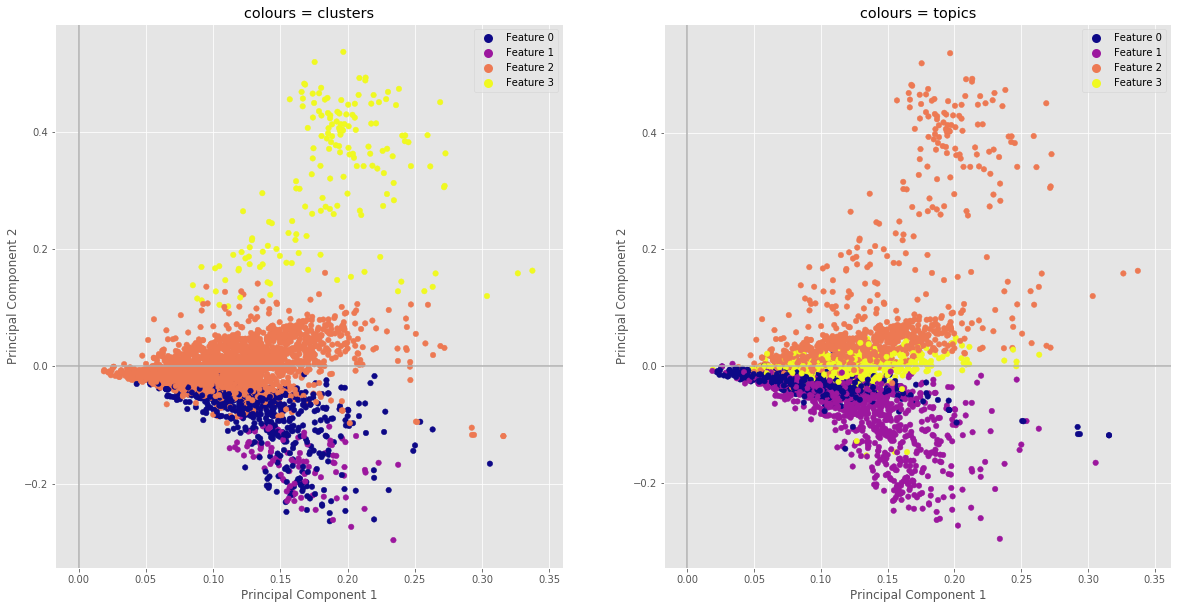

In [0]:
svd = TruncatedSVD(n_components=2)
X_2D_SVD = svd.fit_transform(X.todense())


# рисуем сабплоты
fig, ((plot1, plot2)) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))

# цвета = кластеры
draw_subplots(X_2D_SVD, clf.labels_, plot1, n_clusters, header='colours = clusters', cmap='plasma', plot_centers=False)

# цвета = темы
draw_subplots(X_2D_SVD, labels, plot2, n_clusters, header='colours = topics', cmap='plasma', plot_centers=False)

#### PCA

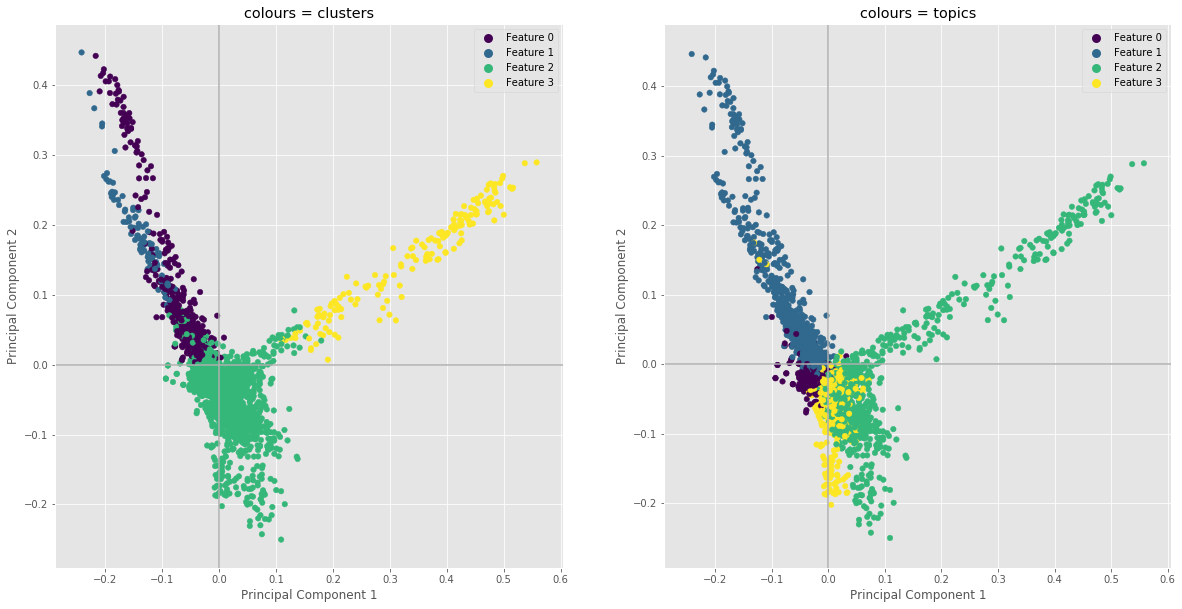

In [0]:
pca = PCA(n_components=2)
X_2D_PCA = pca.fit_transform(X.todense())
centers = pca.transform(clf.cluster_centers_)

# рисуем сабплоты
fig, ((plot1, plot2)) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))

# цвета = кластеры
draw_subplots(X_2D_PCA, clf.labels_, plot1, n_clusters, header='colours = clusters')

# цвета = темы
draw_subplots(X_2D_PCA, labels, plot2, n_clusters, header='colours = topics')

### LDA

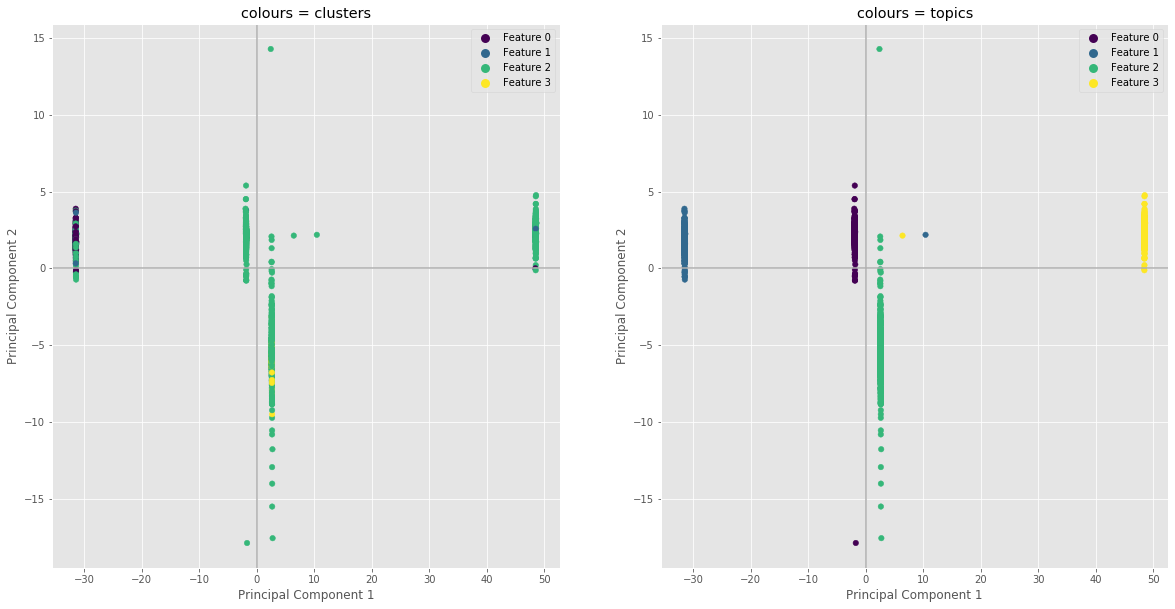

In [0]:

lda = LinearDiscriminantAnalysis(n_components=2)

X_2D_LDA = lda.fit(X.todense(), labels).transform(X.todense())

# рисуем сабплоты
fig, ((plot1, plot2)) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))

# цвета = кластеры
draw_subplots(X_2D_LDA, clf.labels_, plot1, n_clusters, header='colours = clusters')

# цвета = темы
draw_subplots(X_2D_LDA, labels, plot2, n_clusters, header='colours = topics')


#### t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3528 samples in 8.064s...
[t-SNE] Computed neighbors for 3528 samples in 1060.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3528
[t-SNE] Computed conditional probabilities for sample 2000 / 3528
[t-SNE] Computed conditional probabilities for sample 3000 / 3528
[t-SNE] Computed conditional probabilities for sample 3528 / 3528
[t-SNE] Mean sigma: 0.430297
[t-SNE] Computed conditional probabilities in 0.249s
[t-SNE] Iteration 50: error = 81.7878876, gradient norm = 0.0099566 (50 iterations in 2.704s)
[t-SNE] Iteration 100: error = 81.7874908, gradient norm = 0.0072081 (50 iterations in 2.951s)
[t-SNE] Iteration 150: error = 81.7874680, gradient norm = 0.0070243 (50 iterations in 3.010s)
[t-SNE] Iteration 200: error = 81.7874603, gradient norm = 0.0070394 (50 iterations in 2.982s)
[t-SNE] Iteration 250: error = 81.7874146, gradient norm = 0.0065403 (50 iterations in 2.757s)
[t-SNE] KL divergence after 250 ite

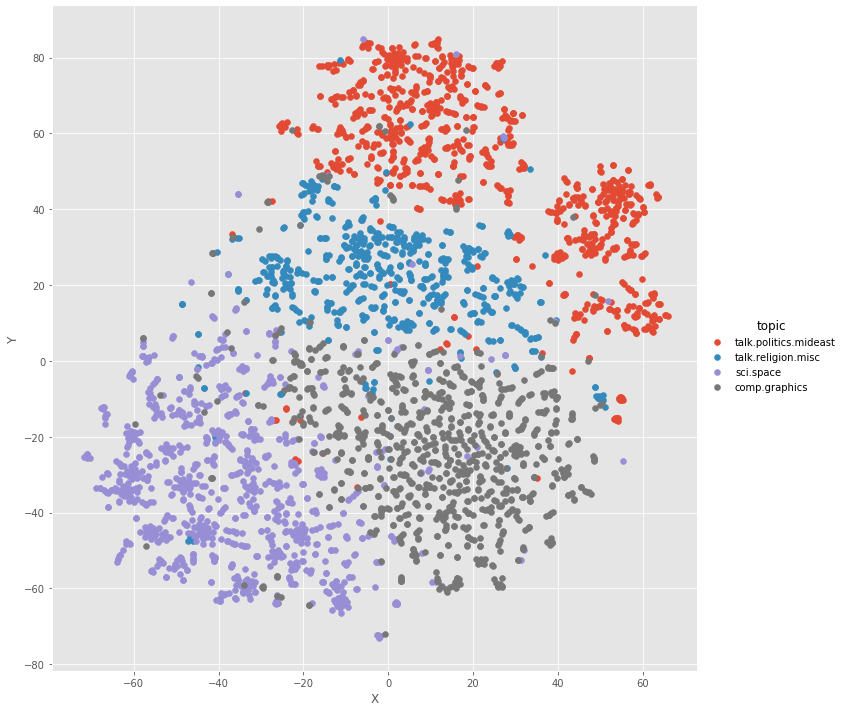

In [0]:
%time X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X.todense())

# достаем названия тем по их номерам
topics = [dataset.target_names[t] for t in labels]

df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : topics})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

##### Хаки с t-SNE
Можно предснизить размерность e.g. PCA, а потом применять t-SNE. Говорят, иногда работает лучше.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3528 samples in 0.005s...
[t-SNE] Computed neighbors for 3528 samples in 1.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3528
[t-SNE] Computed conditional probabilities for sample 2000 / 3528
[t-SNE] Computed conditional probabilities for sample 3000 / 3528
[t-SNE] Computed conditional probabilities for sample 3528 / 3528
[t-SNE] Mean sigma: 0.082277
[t-SNE] Computed conditional probabilities in 0.293s
[t-SNE] Iteration 50: error = 79.9422073, gradient norm = 0.0335193 (50 iterations in 2.762s)
[t-SNE] Iteration 100: error = 75.8872375, gradient norm = 0.0046648 (50 iterations in 1.627s)
[t-SNE] Iteration 150: error = 75.6899796, gradient norm = 0.0015472 (50 iterations in 1.544s)
[t-SNE] Iteration 200: error = 75.6814117, gradient norm = 0.0006289 (50 iterations in 1.572s)
[t-SNE] Iteration 250: error = 75.6824036, gradient norm = 0.0034354 (50 iterations in 1.515s)
[t-SNE] KL divergence after 250 iterat

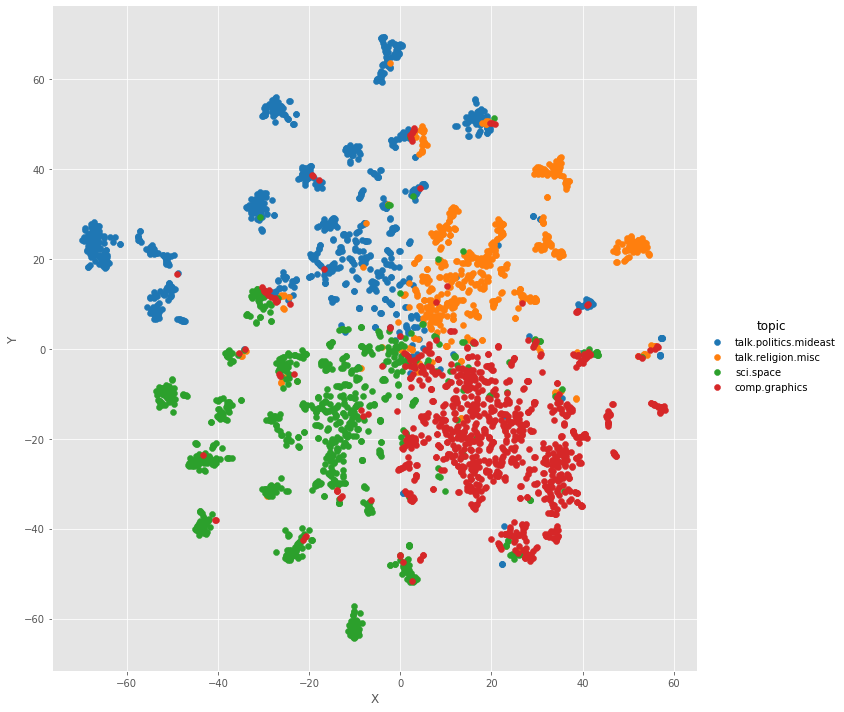

In [0]:
svd50 = TruncatedSVD(n_components=50)
X_50_SVD = svd50.fit_transform(X.todense())
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_50_SVD)

sns.set_palette('tab10')

# достаем названия тем по их номерам
topics = [dataset.target_names[t] for t in labels]

df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : topics})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3528 samples in 0.003s...
[t-SNE] Computed neighbors for 3528 samples in 0.795s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3528
[t-SNE] Computed conditional probabilities for sample 2000 / 3528
[t-SNE] Computed conditional probabilities for sample 3000 / 3528
[t-SNE] Computed conditional probabilities for sample 3528 / 3528
[t-SNE] Mean sigma: 0.049260
[t-SNE] Computed conditional probabilities in 0.296s
[t-SNE] Iteration 50: error = 78.5345917, gradient norm = 0.0512617 (50 iterations in 2.415s)
[t-SNE] Iteration 100: error = 72.4468536, gradient norm = 0.0025396 (50 iterations in 1.678s)
[t-SNE] Iteration 150: error = 72.3244781, gradient norm = 0.0020270 (50 iterations in 1.666s)
[t-SNE] Iteration 200: error = 72.3173523, gradient norm = 0.0004234 (50 iterations in 1.709s)
[t-SNE] Iteration 250: error = 72.3163757, gradient norm = 0.0002260 (50 iterations in 1.736s)
[t-SNE] KL divergence after 250 iterat

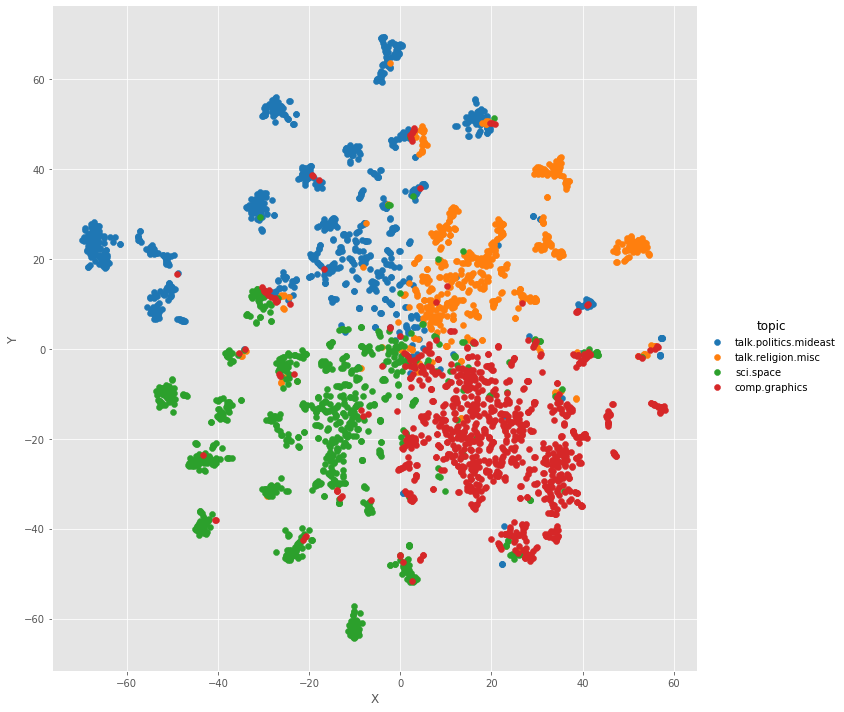

In [0]:
pca30 = PCA(n_components=30)
X_30_PCA = pca30.fit_transform(X.todense())
X_embedded_2 = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_30_PCA)

sns.set_palette('tab10')

# достаем названия тем по их номерам
topics = [dataset.target_names[t] for t in labels]

df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : topics})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

### UMAP



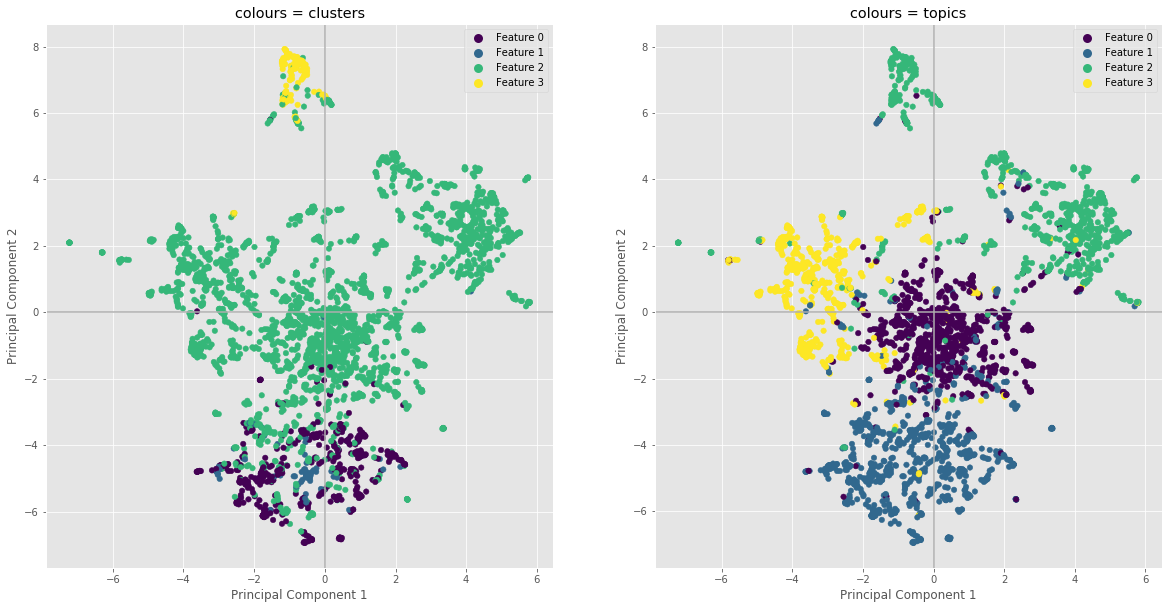

In [0]:
umap_emb = umap.UMAP()
X_2D_umap = umap_emb.fit_transform(X.todense())


# рисуем сабплоты
fig, ((plot1, plot2)) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))

# цвета = кластеры
draw_subplots(X_2D_umap, clf.labels_, plot1, n_clusters, header='colours = clusters')

# цвета = темы
draw_subplots(X_2D_umap, labels, plot2, n_clusters, header='colours = topics')

## Задание
#### 1
Проделайте все то же самое с другим набором тем или на каком-нибудь вашем датасете.  
Хорошо ли отделяются друг от друга близкие темы (например, 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space')?  
Соответствует ли количество тем количеству кластеров, или же кластеров на глаз больше/меньше?

#### 2
Задайте побольше классов (например, 20) в KMeans, а потом преобразуйте данные с помощью t-SNE и раскрасьте точки на графике в соответствии с полученными из KMeans кластерами.  
Насколько результаты кластеризации совпадают с проекцией t-SNE?

#### 3
Возьмите датасет русских новостей, e.g. той же Ленты, что и на всех занятиях, сделайте снижение размерности и посмотрите, сочетается ли оно с оригинальными классами.

# Тематическое моделирование


In [0]:
!wget https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/rus_stopwords.txt
!wget https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/polkrug_lem.txt

--2019-10-29 18:02:10--  https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/rus_stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4322 (4.2K) [text/plain]
Saving to: ‘rus_stopwords.txt’

rus_stopwords.txt   100%[===================>]   4.22K  --.-KB/s    in 0s      

2019-10-29 18:02:10 (57.7 MB/s) - ‘rus_stopwords.txt’ saved [4322/4322]

--2019-10-29 18:02:12--  https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/polkrug_lem.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18267211 (1

In [0]:
with open('rus_stopwords.txt', 'r', encoding='utf-8') as f:
    sw = f.read().split('\n')
    
sw[40:50]

['ведь',
 'весь',
 'весьма',
 'видеть',
 'видит',
 'вместе',
 'во',
 'восемь',
 'вот',
 'впрочем']

In [0]:

with open('polkrug_lem.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
texts = text.split('\n\n')

punct = '[!"#$%&()*+,./:;<=>?@[\]^_`{|}~„“«»†*/\—–‘’]'

texts = [re.sub('\n', ' ', text) for text in texts]
texts = [re.sub(punct, '', text) for text in texts]

tokenized_texts = []
for text in texts:
    text = [w for w in text.split() if w not in sw]
    tokenized_texts.append(text)
    
tokenized_texts[0][:10]

['лев',
 'толстой',
 'анна',
 'каренина',
 'писать',
 'счастливый',
 'семья',
 'похожий',
 'друг',
 'друг']

In [0]:
from gensim.models import *
from gensim import corpora
from gensim import similarities


print('Making dictionary...')
dictionary = corpora.Dictionary(tokenized_texts)
print('Original: {}'.format(dictionary))
dictionary.filter_extremes(no_below = 5, no_above = 0.9, keep_n=None)
dictionary.save('polkrug.dict')
print('Filtered: {}'.format(dictionary))

print('Vectorizing corpus...')
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
corpora.MmCorpus.serialize('polkrug.model', corpus)

Making dictionary...


NameError: ignored

In [0]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

# tf-idf векторах
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# создание случайной выборки
sampling_tfidf = random.choices(corpus_tfidf, k=30)

# вычисление сходства по косинусной мере на tf-idf векторах
index = similarities.MatrixSimilarity(sampling_tfidf)
sims = index[sampling_tfidf]

plt.figure(figsize = (12,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

In [0]:
lsi = lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=5, chunksize=50)


In [0]:
lsi.show_topics(num_topics=5, num_words=10, formatted=False) # можно показать не все темы, а только часть


[(0,
  [('год', 0.3773873006608458),
   ('город', 0.23336662948879539),
   ('салехард', 0.2153879352123701),
   ('работа', 0.17142590639985283),
   ('день', 0.1483354651533088),
   ('человек', 0.14314857242856063),
   ('россия', 0.12241392516942914),
   ('ребенок', 0.12110045021664902),
   ('городской', 0.10889760636530484),
   ('округ', 0.10420592610513965)]),
 (1,
  [('год', -0.34569587314998884),
   ('война', -0.18503674480097204),
   ('салехард', 0.1617948071686107),
   ('сторона', 0.1445209004031011),
   ('город', 0.13437234162868125),
   ('полиция', 0.13246652298057854),
   ('победа', -0.12239115787516859),
   ('работа', 0.10607344932001116),
   ('май', -0.10483660201765609),
   ('великий', -0.1040715754704741)]),
 (2,
  [('война', -0.19164517485359478),
   ('победа', -0.15899616892905855),
   ('июнь', 0.14841629621355323),
   ('россия', 0.14686299628502203),
   ('улица', 0.13971407687057907),
   ('библиотека', 0.13794187009664385),
   ('социальный', -0.1374244525937885),
   ('ма

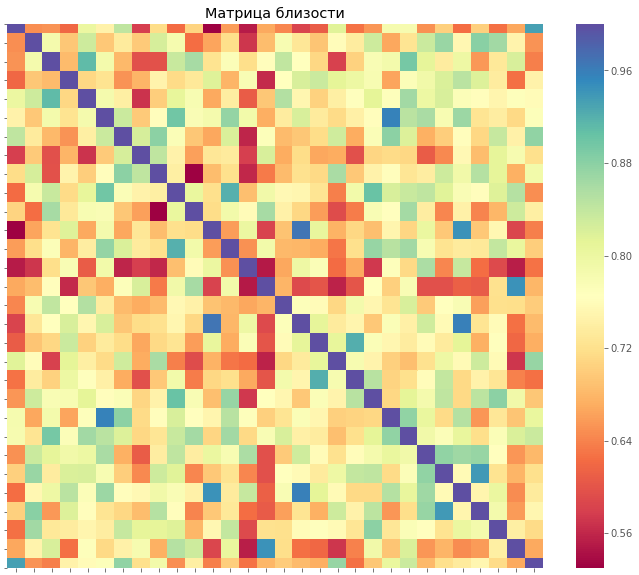

In [0]:
sampling = random.choices(corpus, k=30)

sampling_lsi = lsi[sampling]
index = similarities.MatrixSimilarity(lsi[sampling])
sims = index[sampling_lsi]
sims  = (sims + 1)/2.

plt.figure(figsize = (12,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

In [0]:

%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 16 s, sys: 7.27 s, total: 23.2 s
Wall time: 14.5 s


In [0]:
lda.show_topics(num_topics=5, num_words=10, formatted=False)


[(0,
  [('обдорск', 0.047329813),
   ('обдорский', 0.026150472),
   ('русский', 0.024763199),
   ('век', 0.01981952),
   ('церковь', 0.016855637),
   ('год', 0.015993552),
   ('север', 0.015357372),
   ('сибирский', 0.015014043),
   ('петр', 0.012986961),
   ('история', 0.012720014)]),
 (1,
  [('депутат', 0.027012568),
   ('избирательный', 0.020712968),
   ('председатель', 0.020621764),
   ('дума', 0.018349843),
   ('день', 0.018249553),
   ('партия', 0.018023165),
   ('среда', 0.016112177),
   ('россия', 0.016037744),
   ('кандидат', 0.013308655),
   ('комиссия', 0.0130622)]),
 (5,
  [('год', 0.025684536),
   ('жизнь', 0.020765413),
   ('ребенок', 0.017355043),
   ('человек', 0.016500393),
   ('семья', 0.014552379),
   ('жить', 0.00938039),
   ('друг', 0.008808674),
   ('учитель', 0.0078041125),
   ('становиться', 0.0069405246),
   ('мир', 0.0063472767)]),
 (9,
  [('дело', 0.018737093),
   ('штука', 0.014743588),
   ('отдел', 0.014241426),
   ('сотрудник', 0.013549874),
   ('омвд', 0.

In [0]:


%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 11.3 s, sys: 1.81 s, total: 13.1 s
Wall time: 10min 20s


# Эмбеддинги слов

In [0]:
!wget https://rusvectores.org/static/models/news_upos_cbow_300_2_2017.bin.gz

--2019-10-29 17:53:17--  https://rusvectores.org/static/models/news_upos_cbow_300_2_2017.bin.gz
Resolving rusvectores.org (rusvectores.org)... 116.203.104.23
Connecting to rusvectores.org (rusvectores.org)|116.203.104.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140310878 (134M) [application/x-gzip]
Saving to: ‘news_upos_cbow_300_2_2017.bin.gz’

news_upos_cbow_300_ 100%[===================>] 133.81M  16.9MB/s    in 9.6s    

2019-10-29 17:53:27 (14.0 MB/s) - ‘news_upos_cbow_300_2_2017.bin.gz’ saved [140310878/140310878]



In [0]:
!gunzip news_upos_cbow_300_2_2017.bin.gz

In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format("news_upos_cbow_300_2_2017.bin", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
words = ['день_NOUN', 'ночь_NOUN', 'человек_NOUN', 'семантика_NOUN', 'студент_NOUN', 'студент_ADJ']


for word in words:
    # есть ли слово в модели? Может быть, и нет
    if word in model:
        print(word)
        # выдаем 10 ближайших соседей слова:
        print(model.get_vector(word).shape)
        for i in model.most_similar(positive=[word], topn=10):
            # слово + коэффициент косинусной близости
            print(i[0], i[1])
        print('\n')
    else:
        # Увы!
        print(word + ' is not present in the model')

Для каждого документа получить вектор &mdash; сумму всех его слов, использовать вместо Tf-Idf представления. Попробовать снижение размерности. 

Документы можно брать из прошлых тетрадок или из этой -- выше есть газета "Полярный круг"

In [0]:
with open('polkrug_lem.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
texts = text.split('\n\n')

punct = '[!"#$%&()*+,./:;<=>?@[\]^_`{|}~„“«»†*/\—–‘’]'

texts = [re.sub('\n', ' ', text) for text in texts]
texts = [re.sub(punct, '', text) for text in texts]

tokenized_texts = []
for text in texts:
    text = [w for w in text.split() if w not in sw]
    tokenized_texts.append(text)
    
tokenized_texts[0][:10]

from gensim.models import *
from gensim import corpora
from gensim import similarities


print('Making dictionary...')
dictionary = corpora.Dictionary(tokenized_texts)
print('Original: {}'.format(dictionary))
dictionary.filter_extremes(no_below = 5, no_above = 0.9, keep_n=None)
dictionary.save('polkrug.dict')
print('Filtered: {}'.format(dictionary))

print('Vectorizing corpus...')
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
corpora.MmCorpus.serialize('polkrug.model', corpus)

Making dictionary...
Original: Dictionary(43034 unique tokens: ['10', '1964', 'август', 'адрес', 'анна']...)
Filtered: Dictionary(12866 unique tokens: ['10', '1964', 'август', 'адрес', 'анна']...)
Vectorizing corpus...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
!wget https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/rus_stopwords.txt
!wget https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/polkrug_lem.txt

polkrug_texts = [line for line in open('polkrug_lem.txt', 'r', encoding='utf-8')]


--2019-10-29 18:05:37--  https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/rus_stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4322 (4.2K) [text/plain]
Saving to: ‘rus_stopwords.txt’

rus_stopwords.txt   100%[===================>]   4.22K  --.-KB/s    in 0s      

2019-10-29 18:05:37 (98.4 MB/s) - ‘rus_stopwords.txt’ saved [4322/4322]

--2019-10-29 18:05:38--  https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/polkrug_lem.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18267211 (1

In [0]:



!wget https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/rus_stopwords.txt
!wget https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/polkrug_lem.txt
!wget https://rusvectores.org/static/models/news_upos_cbow_300_2_2017.bin.gz
!gunzip news_upos_cbow_300_2_2017.bin.gz


In [0]:

import umap
import pymorphy2
import gensim
import numpy as np
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


processed 0 of 10000
processed 100 of 10000
processed 200 of 10000
processed 300 of 10000
processed 400 of 10000
processed 500 of 10000
processed 600 of 10000
processed 700 of 10000
processed 800 of 10000
processed 900 of 10000
processed 1000 of 10000
processed 1100 of 10000
processed 1200 of 10000
processed 1300 of 10000
processed 1400 of 10000
processed 1500 of 10000
processed 1600 of 10000
processed 1700 of 10000
processed 1800 of 10000
processed 1900 of 10000
processed 2000 of 10000
processed 2100 of 10000
processed 2200 of 10000
processed 2300 of 10000
processed 2400 of 10000
processed 2500 of 10000
processed 2600 of 10000
processed 2700 of 10000
processed 2800 of 10000
processed 2900 of 10000
processed 3000 of 10000
processed 3100 of 10000
processed 3200 of 10000
processed 3300 of 10000
processed 3400 of 10000
processed 3500 of 10000
processed 3600 of 10000
processed 3700 of 10000
processed 3800 of 10000
processed 3900 of 10000
processed 4000 of 10000
processed 4100 of 10000
proc

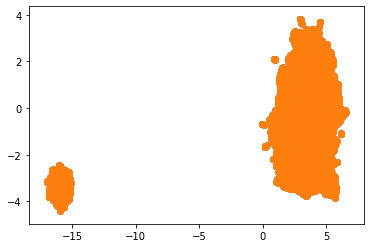

In [0]:

polkrug_texts = [line for line in open('polkrug_lem.txt', 'r', encoding='utf-8')][:10000]
w2v_model = gensim.models.KeyedVectors.load_word2vec_format("news_upos_cbow_300_2_2017.bin", binary=True)


morph_analyzer =  pymorphy2.MorphAnalyzer()
polkrug_texts_vectorized = []
for text_idx, text in enumerate(polkrug_texts):
    text_vs = []
    for word in text.split():
        pos_tag = morph_analyzer.parse(word)[0].tag.POS
        pos_tagged_word = f"{word}_{pos_tag}"
        if word.isalpha() and pos_tagged_word in w2v_model:
            word_v = w2v_model.get_vector(pos_tagged_word)
            # print(f"found {pos_tagged_word}")
            text_vs.append(word_v)
    if text_vs:
        text_v = np.mean(np.array(text_vs), axis=0)
        polkrug_texts_vectorized.append((text, text_v))
    if text_idx % 100 == 0:
        print(f"processed {str(text_idx)} of {str(len(polkrug_texts))}")

umap_emb = umap.UMAP()
X_2D_umap = umap_emb.fit_transform([e[1] for e in polkrug_texts_vectorized])

for i in range(2):
    plt.scatter(X_2D_umap[i:,0], X_2D_umap[i:,1])